In [1]:
from simpeg import (
    maps, utils, data, optimization, maps, regularization, 
    inverse_problem, directives, inversion, data_misfit
)
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from simpeg.electromagnetics import natural_source as nsem
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from matplotlib.colors import LogNorm
from ipywidgets import interact, widgets
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

(49, 3)


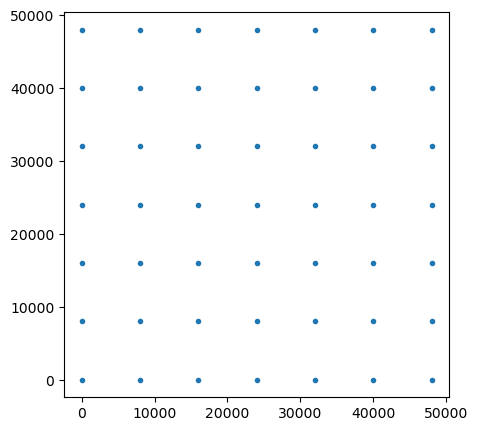

In [2]:
frequencies = np.array([0.1, 2.])
station_spacing = 8000
factor_spacing = 4
rx_x, rx_y = np.meshgrid(np.arange(0, 50000, station_spacing), np.arange(0, 50000, station_spacing))
rx_loc = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1))))
print(rx_loc.shape)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(rx_loc[:, 0], rx_loc[:, 1], '.')
ax.set_aspect(1)

In [3]:
import discretize.utils as dis_utils
from discretize import TreeMesh
from geoana.em.fdem import skin_depth

def get_octree_mesh(
    rx_loc, frequencies, sigma_background, station_spacing,
    factor_x_pad=2,
    factor_y_pad=2,
    factor_z_pad_down=2,
    factor_z_core=1,
    factor_z_pad_up=1,
    ):
    f_min =  frequencies.min()
    f_max =  frequencies.max()
    lx_pad = skin_depth(f_min, sigma_background) * factor_x_pad
    ly_pad = skin_depth(f_min, sigma_background) * factor_y_pad
    lz_pad_down = skin_depth(f_min, sigma_background) * factor_z_pad_down
    lz_core = skin_depth(f_min, sigma_background) * factor_z_core
    lz_pad_up = skin_depth(f_min, sigma_background) * factor_z_pad_up

    lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
    ly_core = rx_loc[:,1].max() - rx_loc[:,1].min()
    lx = lx_pad + lx_core + lx_pad
    ly = ly_pad + ly_core + ly_pad
    lz = lz_pad_down + lz_core + lz_pad_up
    dx = station_spacing / factor_spacing
    dy = station_spacing / factor_spacing
    dz = np.round(skin_depth(f_max, sigma_background) /4, decimals=-1)

    # Compute number of base mesh cells required in x and y
    nbcx = 2 ** int(np.ceil(np.log(lx / dx) / np.log(2.0)))
    nbcy = 2 ** int(np.ceil(np.log(ly / dy) / np.log(2.0)))
    nbcz = 2 ** int(np.ceil(np.log(lz / dz) / np.log(2.0)))
    
    mesh = dis_utils.mesh_builder_xyz(
        rx_loc, 
        [dx, dy, dz],
        padding_distance=[[lx_pad, lx_pad], [ly_pad, ly_pad], [lz_pad_down, lz_pad_up]],
        depth_core=lz_core,
        mesh_type='tree'
    )
    X, Y = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
    topo = np.c_[X.flatten(), Y.flatten(), np.zeros(X.size)]
    mesh = refine_tree_xyz(
        mesh, topo, octree_levels=[0, 0, 4], method="surface", finalize=False
    )

    mesh = refine_tree_xyz(
        mesh, rx_loc, octree_levels=[1, 2, 1], method="radial", finalize=True
    )    
    return mesh

In [4]:
mesh = get_octree_mesh(rx_loc, frequencies, 1e-2, station_spacing)

/var/folders/r9/bx9nxyhn04vb2y8frjczdfw80000gn/T/ipykernel_12869/181399982.py:44: DeprecationWarning: The surface option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_surface` functionality. It will be removed in a future version of discretize.
  mesh = refine_tree_xyz(
/var/folders/r9/bx9nxyhn04vb2y8frjczdfw80000gn/T/ipykernel_12869/181399982.py:48: DeprecationWarning: The radial option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_points` functionality. It will be removed in a future version of discretize.
  mesh = refine_tree_xyz(


In [5]:
sigma_background = np.ones(mesh.nC) * 1e-8
ind_active = mesh.cell_centers[:,2] < 0.
sigma_background[ind_active] = 1e-2

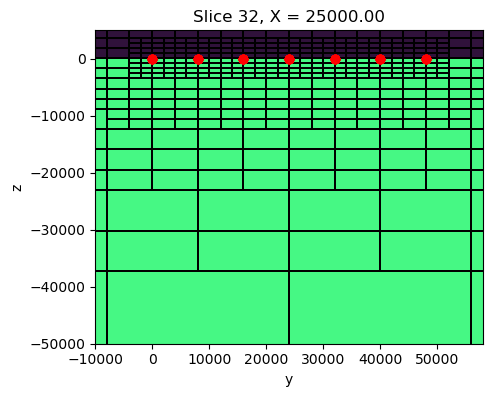

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
mesh.plot_slice(
    sigma_background, grid=True, normal='X', ax=ax,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-4, vmax=10)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min()-10000, rx_loc[:,0].max()+10000), 
    range_y=(-50000, 50000*0.1)
)
ax.plot(rx_loc[:,0], rx_loc[:,2], 'ro')
ax.set_aspect(1)

In [7]:
## create target blocks
ind_block_1 = utils.model_builder.get_indices_block([8000, 44000, -5000], [44000, 36000, -10000], mesh.gridCC)[0].tolist()
ind_block_2 = utils.model_builder.get_indices_block([36000, 44000, -5000], [44000, 8000, -10000], mesh.gridCC)[0].tolist()
# print(block_1)
sigma = sigma_background.copy()
sigma[ind_block_1] = 1.
sigma[ind_block_2] = 1.

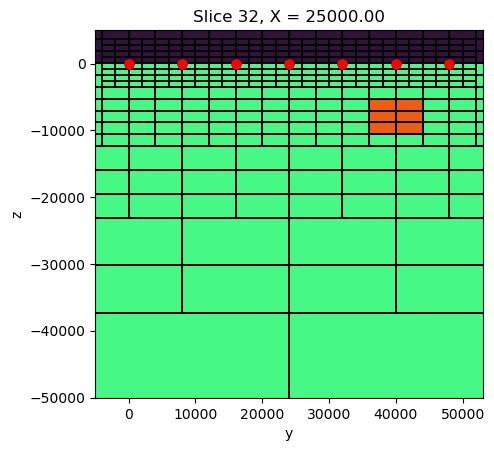

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
mesh.plot_slice(
    sigma, grid=True, normal='X', ax=ax,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-4, vmax=10)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(-50000, 50000*0.1)
)
ax.plot(rx_loc[:,0], rx_loc[:,2], 'ro')
ax.set_aspect(1)

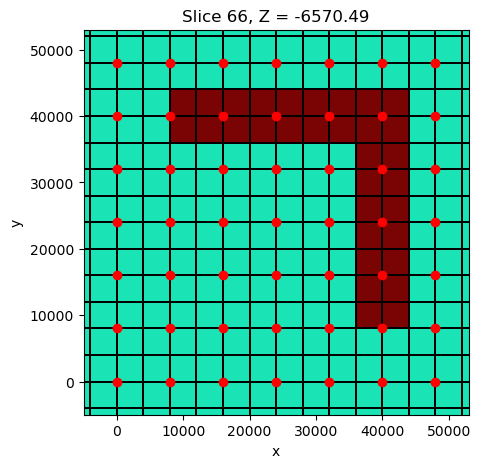

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
mesh.plot_slice(
    sigma, grid=True, normal='Z', ax=ax,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=-7000.
)
ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')
ax.set_aspect(1)

In [10]:
# Generate a Survey
rx_list = []
rx_orientations_impedance = ['xy', 'yx', 'xx', 'yy']
for rx_orientation in rx_orientations_impedance:    
    rx_list.append(     
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
rx_orientations_tipper = ['zx', 'zy']
for rx_orientation in rx_orientations_tipper:    
    rx_list.append(     
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        nsem.receivers.Point3DTipper(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )
# Source list
src_list = [nsem.sources.PlanewaveXYPrimary(rx_list, frequency=f) for f in frequencies]

# split by chunks of sources

mt_sims = []
mt_mappings = []
surveys = []
for i in range(len(src_list)):
    # Set the mapping
    active_map = maps.InjectActiveCells(
        mesh=mesh, indActive=ind_active, valInactive=np.log(1e-8)
    )
    mapping = maps.ExpMap(mesh) * active_map    
    survey_chunk = nsem.Survey(src_list[i])
    mt_sims.append(
        nsem.simulation.Simulation3DPrimarySecondary(    
            mesh,
            survey=survey_chunk,
            sigmaMap=maps.IdentityMap(),
            sigmaPrimary=sigma_background,
            solver=Solver
        )
    )
    surveys.append(survey_chunk)
    mt_mappings.append(mapping)
    print (f"{i}, {frequencies[i]:.1f} Hz")

0, 0.1 Hz
1, 2.0 Hz


In [11]:
rx_orientations = rx_orientations_impedance + rx_orientations_tipper

In [12]:
from simpeg.meta import MultiprocessingMetaSimulation
parallel_sim = MultiprocessingMetaSimulation(mt_sims, mt_mappings, n_processes=2)

/Users/Mike/miniconda3/envs/em/lib/python3.12/site-packages/simpeg/meta/multiprocessing.py:241: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  super().__init__(simulations, mappings)
/Users/Mike/miniconda3/envs/em/lib/python3.12/site-packages/simpeg/meta/multiprocessing.py:260: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  sim_chunk = MetaSimulation(


In [13]:
len(frequencies)

2

In [14]:
m_true = np.log(sigma[ind_active])

In [15]:
dpred = parallel_sim.dpred(m_true)

In [16]:
# plt.plot(dpred, '.')
# plt.plot(dpred_serial, 'x')

In [17]:
# # True model 
# m_true = np.log(sigma[ind_active])

# # Setup the problem object
# simulation = nsem.simulation.Simulation3DPrimarySecondary(    
#     mesh,
#     survey=survey,
#     sigmaMap=mapping,
#     sigmaPrimary=sigma_background,
#     # solver=Solver

# )
# dpred = simulation.dpred(m_true)

In [18]:
relative_error = 0.05
n_rx = rx_loc.shape[0]
n_freq = len(frequencies)
n_component = 2
n_orientation = len(rx_orientations)

DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
DCLEAN = DOBS.copy()
FLOOR = np.zeros_like(DOBS)
FLOOR[:,2,0,:] = np.percentile(abs(DOBS[:,2,0,:].flatten()), 90) * 0.1
FLOOR[:,2,1,:] = np.percentile(abs(DOBS[:,2,1,:].flatten()), 90) * 0.1
FLOOR[:,3,0,:] = np.percentile(abs(DOBS[:,3,0,:].flatten()), 90) * 0.1
FLOOR[:,3,1,:] = np.percentile(abs(DOBS[:,3,1,:].flatten()), 90) * 0.1
FLOOR[:,4,0,:] = np.percentile(abs(DOBS[:,4,0,:].flatten()), 90) * 0.1
FLOOR[:,4,1,:] = np.percentile(abs(DOBS[:,4,1,:].flatten()), 90) * 0.1
FLOOR[:,5,0,:] = np.percentile(abs(DOBS[:,5,0,:].flatten()), 90) * 0.1
FLOOR[:,5,1,:] = np.percentile(abs(DOBS[:,5,1,:].flatten()), 90) * 0.1
STD = abs(DOBS) * relative_error + FLOOR
# STD = (FLOOR)
standard_deviation = STD.flatten()
dobs = DOBS.flatten() 
dobs += abs(dobs) * relative_error * np.random.randn(dobs.size)
DOBS = dobs.reshape((n_freq, n_orientation, n_component, n_rx))
# + standard_deviation * np.random.randn(standard_deviation.size)

In [19]:
components = ['Real', 'Imag']

In [20]:
def foo_data(i_freq, i_orientation, i_component):
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    vmin = np.min([DOBS[i_freq, i_orientation, i_component,:].min(), DCLEAN[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([DOBS[i_freq, i_orientation, i_component,:].max(), DCLEAN[i_freq, i_orientation, i_component,:].max()])
    out1 = utils.plot2Ddata(rx_loc, DCLEAN[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax, contourOpts={'cmap':'turbo'}, ncontour=20)
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    if i_orientation<4:
        transfer_type = "Z"
    else:
        transfer_type = "T"
    ax.set_title("Frequency={:.1e}, {:s}{:s}-{:s}".format(frequencies[i_freq], transfer_type, rx_orientations[i_orientation], components[i_component]))

In [21]:
interact(
    foo_data,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
    i_component=widgets.IntSlider(min=0, max=n_component-1), 
)

interactive(children=(IntSlider(value=0, description='i_freq', max=1), IntSlider(value=0, description='i_orien…

<function __main__.foo_data(i_freq, i_orientation, i_component)>

In [22]:
# Assign uncertainties
# make data object
data_object = data.Data(parallel_sim.survey, dobs=dobs, standard_deviation=standard_deviation)

In [23]:
m_0 = np.log(sigma_background[ind_active])
dpred0 = parallel_sim.dpred(m_0)

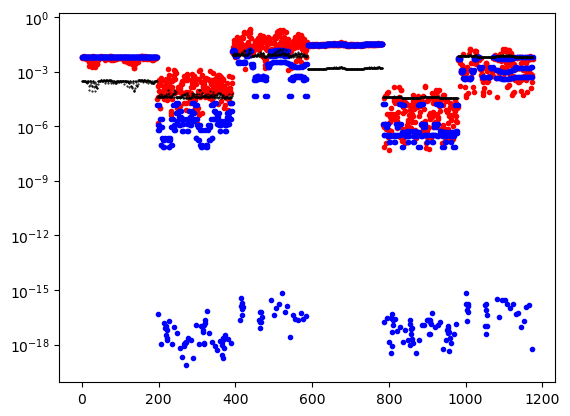

In [24]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy(abs(dpred0), '.b')
plt.semilogy((data_object.standard_deviation), 'k.', ms=1)

plt.show()

In [25]:
1./(mesh.h[0]**2)

array([2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07, 2.5e-07,
       2.5e-07])

In [26]:
# Optimization
opt = optimization.ProjectedGNCG(maxIter=10, maxIterCG=20, upper=np.inf, lower=-np.inf)
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=parallel_sim)
# Regularization
dz = mesh.h[2].min()
dx = mesh.h[0].min()
regmap = maps.IdentityMap(nP=int(ind_active.sum()))
reg = regularization.Sparse(mesh, active_cells=ind_active, mapping=regmap)
reg.alpha_s = 1e-10
reg.alpha_x = dz/dx
reg.alpha_y = dz/dx
reg.alpha_z = 1.

# Inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
# Beta schedule
beta = directives.BetaSchedule(coolingRate=1, coolingFactor=2)
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
target = directives.TargetMisfit()
# Create an inversion object
save_dictionary = directives.SaveOutputDictEveryIteration()
directive_list = [beta, beta_est, target, save_dictionary]
inv = inversion.BaseInversion(inv_prob, directiveList=directive_list)

# Set an initial or starting model
m_0 = np.log(sigma_background[ind_active])

import time
start = time.time()
# Run the inversion
mInv = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.35e-02  3.77e+04  0.00e+00  3.77e+04    4.39e+03      0              
   1  1.67e-02  1.45e+04  1.07e+05  1.63e+04    1.08e+03      0              
   2  8.37e-03  1.16e+04  2.12e+05  1.34e+04    6.37e+02      0   Skip BFGS

In [27]:
target.target

1176.0

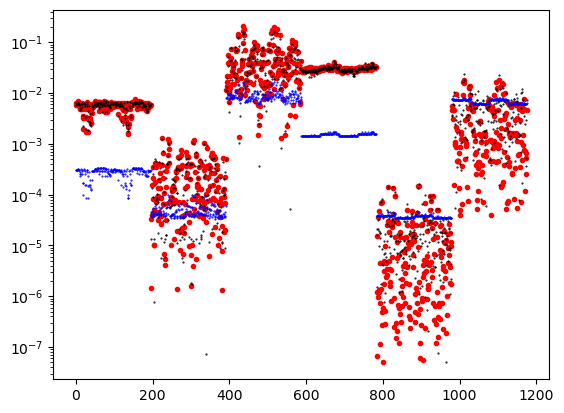

In [28]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy(abs(inv_prob.dpred), 'k.', ms=1)
plt.semilogy(abs(data_object.standard_deviation), 'b.', ms=1)
plt.show()

In [29]:
iteration = len(save_dictionary.outDict)
m = save_dictionary.outDict[iteration]['m']
sigma_est = mapping*m
pred = save_dictionary.outDict[iteration]['dpred']
DPRED = pred.reshape((n_freq, n_orientation, n_component, n_rx))
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
MISFIT = (DPRED-DOBS)/STD

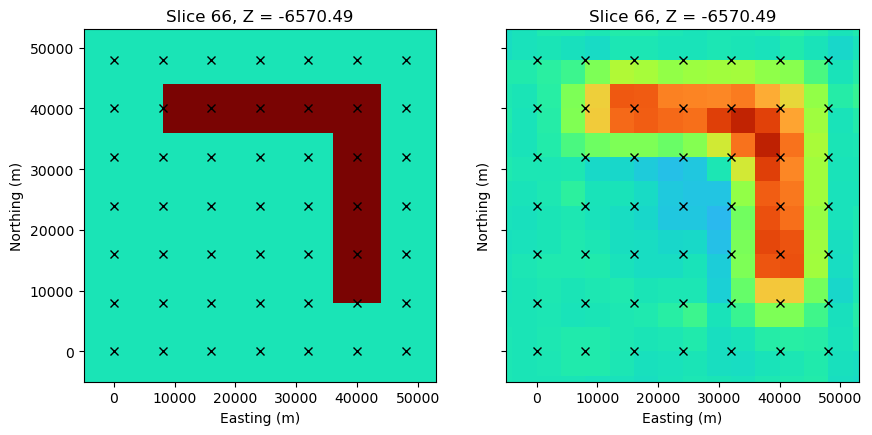

In [30]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
z_loc = -7000.
y_loc = 10000.
mesh.plot_slice(
    sigma, grid=False, normal='Z', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=z_loc
)
mesh.plot_slice(
    sigma_est, grid=False, normal='Z', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=z_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

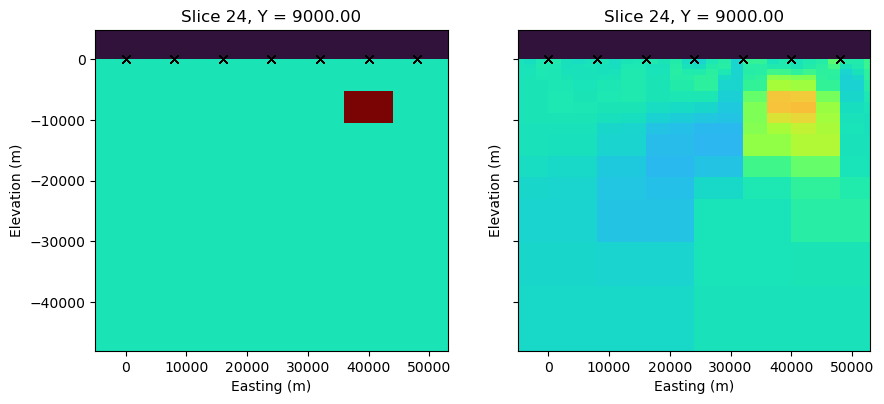

In [31]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
mesh.plot_slice(
    sigma, grid=False, normal='Y', ax=ax1,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(-lx_core, lx_core*0.1),
    slice_loc=y_loc
)
mesh.plot_slice(
    sigma_est, grid=False, normal='Y', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(-lx_core, lx_core*0.1),
    slice_loc=y_loc
)
ax2.set_yticklabels([])
for ax in axs:
    ax.plot(rx_loc[:,0], rx_loc[:,2], 'kx')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")


In [32]:
from ipywidgets import interact, widgets

In [33]:
def foo_misfit(i_freq, i_orientation, i_component):
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    ax1, ax2, ax3 = axs

    vmin = np.min([DOBS[i_freq, i_orientation, i_component,:].min(), DPRED[i_freq, i_orientation, i_component,:].min()])
    vmax = np.max([DOBS[i_freq, i_orientation, i_component,:].max(), DPRED[i_freq, i_orientation, i_component,:].max()])

    out1 = utils.plot2Ddata(rx_loc, DOBS[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax1, contourOpts={'cmap':'turbo'}, ncontour=20)
    out2 = utils.plot2Ddata(rx_loc, DPRED[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax2, contourOpts={'cmap':'turbo'}, ncontour=20)
    out3 = utils.plot2Ddata(rx_loc, MISFIT[i_freq, i_orientation, i_component,:], clim=(-5, 5), ax=ax3, contourOpts={'cmap':'turbo'}, ncontour=20)

    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')

In [34]:
interact(
    foo_misfit,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
    i_component=widgets.IntSlider(min=0, max=n_component-1), 
)

interactive(children=(IntSlider(value=0, description='i_freq', max=1), IntSlider(value=0, description='i_orien…

<function __main__.foo_misfit(i_freq, i_orientation, i_component)>

In [35]:
# models = {}
# models["estimated_sigma"] = sigma_est
# models['true_sigma'] = sigma
# mesh.write_vtk("mt_synthetic",models=models)